In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def build_1d_cnn_custom_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_________________________________________________________________
________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_36 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_37 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.4241 - acc: 0.2211
Epoch 00001: val_loss improved from inf to 2.38455, saving model to model/checkpoint/1D_CNN_1_conv_custom_BN_checkpoint/001-2.3846.hdf5
36805/36805 [==============================] - 37s 999us/sample - loss: 4.4238 - acc: 0.2211 - val_loss: 2.3846 - val_acc: 0.2716
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6626 - acc: 0.5319
Epoch 00002: val_loss did not improve from 2.38455
36805/36805 [==============================] - 35s 945us/sample - loss: 1.6626 - acc: 0.5319 - val_loss: 2.8375 - val_acc: 0.2902
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0306 - acc: 0.6987
Epoch 00003: val_loss did not improve from 2.38455
36805/36805 [==============================] - 35s 944us/sample - loss: 1.0306 - acc: 0.6987 - val_loss: 3.2398 - val

36800/36805 [============================>.] - ETA: 0s - loss: 0.0807 - acc: 0.9871
Epoch 00029: val_loss did not improve from 2.38455
36805/36805 [==============================] - 34s 922us/sample - loss: 0.0807 - acc: 0.9871 - val_loss: 7.8137 - val_acc: 0.2485
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9868
Epoch 00030: val_loss did not improve from 2.38455
36805/36805 [==============================] - 34s 935us/sample - loss: 0.0837 - acc: 0.9868 - val_loss: 7.8375 - val_acc: 0.2383
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9843
Epoch 00031: val_loss did not improve from 2.38455
36805/36805 [==============================] - 34s 926us/sample - loss: 0.0890 - acc: 0.9843 - val_loss: 8.2498 - val_acc: 0.2411
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9870
Epoch 00032: val_loss did not improve from 2.38455
36805/36805 [==================

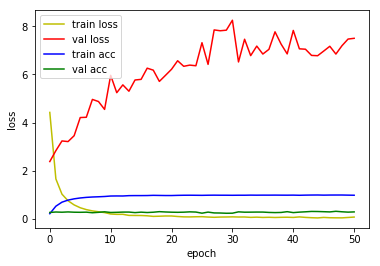

4815/4815 [==============================] - 2s 431us/sample - loss: 2.4178 - acc: 0.2471
Loss: 2.417800233272501 Accuracy: 0.24714434

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.6595 - acc: 0.2658
Epoch 00001: val_loss improved from inf to 5.59948, saving model to model/checkpoint/1D_CNN_2_conv_custom_BN_checkpoint/001-5.5995.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 5.6597 - acc: 0.2658 - val_loss: 5.5995 - val_acc: 0.2013
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8730 - acc: 0.4186
Epoch 00002: val_loss improved from 5.59948 to 5.47810, saving model to model/checkpoint/1D_CNN_2_conv_custom_BN_checkpoint/002-5.4781.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 4.8728 - acc: 0.4186 - val_loss: 5.4781 - val_acc: 0.3058
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.4642 - acc: 0.

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7163 - acc: 0.7614
Epoch 00030: val_loss did not improve from 5.47810
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.7165 - acc: 0.7614 - val_loss: 7.8420 - val_acc: 0.3315
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7762 - acc: 0.7511
Epoch 00031: val_loss did not improve from 5.47810
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.7762 - acc: 0.7511 - val_loss: 7.7235 - val_acc: 0.3399
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7413 - acc: 0.7558
Epoch 00032: val_loss did not improve from 5.47810
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.7412 - acc: 0.7558 - val_loss: 7.8640 - val_acc: 0.3429
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7365 - acc: 0.7586
Epoch 00033: val_loss did not improve from 5.47810
36805/36805 [===========

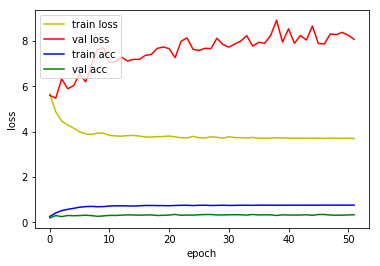

4815/4815 [==============================] - 3s 726us/sample - loss: 5.4226 - acc: 0.2847
Loss: 5.422640151323931 Accuracy: 0.2847352

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0971 - acc: 0.3811
Epoch 00001: val_loss improved from inf to 2.12425, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_checkpoint/001-2.1243.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.0973 - acc: 0.3811 - val_loss: 2.1243 - val_acc: 0.3601
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3314 - acc: 0.5904
Epoch 00002: val_loss improved from 2.12425 to 1.70353, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_checkpoint/002-1.7035.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.3313 - acc: 0.5904 - val_loss: 1.7035 - val_acc: 0.5080
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9733 - acc: 0.6

36800/36805 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9896
Epoch 00029: val_loss did not improve from 1.54844
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0444 - acc: 0.9896 - val_loss: 2.9250 - val_acc: 0.5600
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9878
Epoch 00030: val_loss did not improve from 1.54844
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0487 - acc: 0.9878 - val_loss: 2.8997 - val_acc: 0.5642
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9920
Epoch 00031: val_loss did not improve from 1.54844
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0383 - acc: 0.9920 - val_loss: 2.9120 - val_acc: 0.5649
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9876
Epoch 00032: val_loss did not improve from 1.54844
36805/36805 [========================

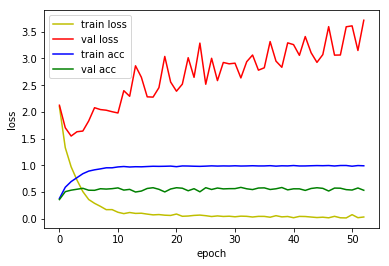

4815/4815 [==============================] - 4s 800us/sample - loss: 1.5859 - acc: 0.5190
Loss: 1.5858815193423847 Accuracy: 0.5190031

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7778 - acc: 0.4445
Epoch 00001: val_loss improved from inf to 1.42883, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_checkpoint/001-1.4288.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.7777 - acc: 0.4445 - val_loss: 1.4288 - val_acc: 0.5658
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1590 - acc: 0.6408
Epoch 00002: val_loss improved from 1.42883 to 1.12775, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_checkpoint/002-1.1277.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.1590 - acc: 0.6408 - val_loss: 1.1277 - val_acc: 0.6420
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9393 - acc: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9937
Epoch 00029: val_loss did not improve from 1.02765
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0354 - acc: 0.9937 - val_loss: 1.5545 - val_acc: 0.6771
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9887
Epoch 00030: val_loss did not improve from 1.02765
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0488 - acc: 0.9887 - val_loss: 1.8203 - val_acc: 0.6557
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9961
Epoch 00031: val_loss did not improve from 1.02765
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0265 - acc: 0.9961 - val_loss: 1.6789 - val_acc: 0.6692
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9957
Epoch 00032: val_loss did not improve from 1.02765
36805/36805 [========================

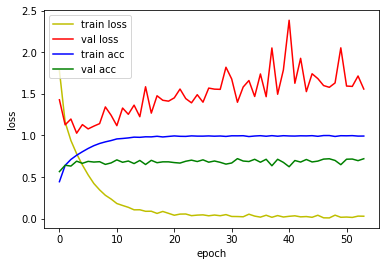

4815/4815 [==============================] - 4s 848us/sample - loss: 1.1050 - acc: 0.6596
Loss: 1.1049580599288702 Accuracy: 0.6596054

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6844 - acc: 0.4728
Epoch 00001: val_loss improved from inf to 1.52621, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_checkpoint/001-1.5262.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.6844 - acc: 0.4728 - val_loss: 1.5262 - val_acc: 0.4705
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0740 - acc: 0.6687
Epoch 00002: val_loss improved from 1.52621 to 1.02134, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_checkpoint/002-1.0213.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.0739 - acc: 0.6687 - val_loss: 1.0213 - val_acc: 0.6904
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8794 - acc: 0.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9908
Epoch 00029: val_loss did not improve from 0.83130
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0463 - acc: 0.9908 - val_loss: 1.2047 - val_acc: 0.7445
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9903
Epoch 00030: val_loss did not improve from 0.83130
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0470 - acc: 0.9903 - val_loss: 0.9922 - val_acc: 0.7820
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9979
Epoch 00031: val_loss did not improve from 0.83130
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0221 - acc: 0.9979 - val_loss: 1.1375 - val_acc: 0.7624
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9906
Epoch 00032: val_loss did not improve from 0.83130
36805/36805 [===========

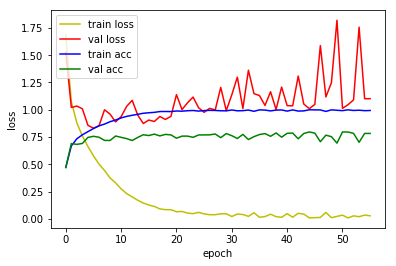

4815/4815 [==============================] - 4s 914us/sample - loss: 0.8905 - acc: 0.7323
Loss: 0.8905373923256142 Accuracy: 0.7322949

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5805 - acc: 0.5044
Epoch 00001: val_loss improved from inf to 1.50168, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_checkpoint/001-1.5017.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.5804 - acc: 0.5044 - val_loss: 1.5017 - val_acc: 0.5113
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9714 - acc: 0.7025
Epoch 00002: val_loss improved from 1.50168 to 0.90135, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_checkpoint/002-0.9013.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.9713 - acc: 0.7025 - val_loss: 0.9013 - val_acc: 0.7207
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7875 - acc: 0.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9923
Epoch 00027: val_loss did not improve from 0.51580
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0526 - acc: 0.9922 - val_loss: 0.6927 - val_acc: 0.8295
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9914
Epoch 00028: val_loss did not improve from 0.51580
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0553 - acc: 0.9913 - val_loss: 0.7882 - val_acc: 0.8067
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0667 - acc: 0.9872
Epoch 00029: val_loss did not improve from 0.51580
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0667 - acc: 0.9872 - val_loss: 0.5806 - val_acc: 0.8553
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9945
Epoch 00030: val_loss did not improve from 0.51580
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9918
Epoch 00057: val_loss did not improve from 0.51580
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0349 - acc: 0.9917 - val_loss: 0.6090 - val_acc: 0.8679
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9949
Epoch 00058: val_loss did not improve from 0.51580
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0255 - acc: 0.9949 - val_loss: 0.5372 - val_acc: 0.8786
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9989
Epoch 00059: val_loss did not improve from 0.51580
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0103 - acc: 0.9989 - val_loss: 0.7220 - val_acc: 0.8484
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9982
Epoch 00060: val_loss did not improve from 0.51580
36805/36805 [===========

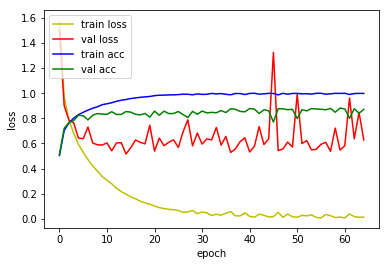

4815/4815 [==============================] - 5s 971us/sample - loss: 0.5919 - acc: 0.8220
Loss: 0.5919152172864536 Accuracy: 0.8220145

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6395 - acc: 0.4930
Epoch 00001: val_loss improved from inf to 1.45261, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_checkpoint/001-1.4526.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.6394 - acc: 0.4930 - val_loss: 1.4526 - val_acc: 0.5490
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9257 - acc: 0.7275
Epoch 00002: val_loss improved from 1.45261 to 0.81903, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_checkpoint/002-0.8190.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.9257 - acc: 0.7275 - val_loss: 0.8190 - val_acc: 0.7699
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6806 - acc: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9904
Epoch 00027: val_loss did not improve from 0.27532
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0473 - acc: 0.9904 - val_loss: 0.3713 - val_acc: 0.9071
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9958
Epoch 00028: val_loss did not improve from 0.27532
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0294 - acc: 0.9958 - val_loss: 0.3125 - val_acc: 0.9196
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9943
Epoch 00029: val_loss did not improve from 0.27532
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0326 - acc: 0.9943 - val_loss: 0.4251 - val_acc: 0.8956
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9942
Epoch 00030: val_loss did not improve from 0.27532
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9992
Epoch 00056: val_loss did not improve from 0.24507
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0066 - acc: 0.9992 - val_loss: 0.2576 - val_acc: 0.9364
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9973
Epoch 00057: val_loss did not improve from 0.24507
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0127 - acc: 0.9973 - val_loss: 0.6564 - val_acc: 0.8593
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9925
Epoch 00058: val_loss did not improve from 0.24507
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0297 - acc: 0.9925 - val_loss: 0.3088 - val_acc: 0.9201
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0056 - acc: 0.9996
Epoch 00059: val_loss did not improve from 0.24507
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9999
Epoch 00086: val_loss did not improve from 0.24507
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0019 - acc: 0.9999 - val_loss: 0.2664 - val_acc: 0.9434
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9968
Epoch 00087: val_loss did not improve from 0.24507
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0125 - acc: 0.9968 - val_loss: 0.3642 - val_acc: 0.9292
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9986
Epoch 00088: val_loss did not improve from 0.24507
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0070 - acc: 0.9986 - val_loss: 0.2862 - val_acc: 0.9320
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9998
Epoch 00089: val_loss did not improve from 0.24507
36805/36805 [===========

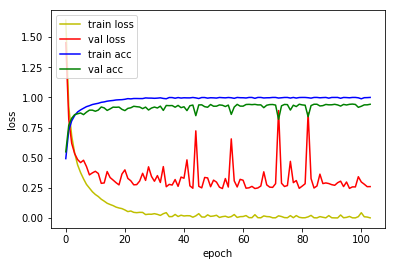

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3502 - acc: 0.9148
Loss: 0.35023604480091286 Accuracy: 0.9148494

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4692 - acc: 0.5581
Epoch 00001: val_loss improved from inf to 1.29661, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_checkpoint/001-1.2966.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.4692 - acc: 0.5580 - val_loss: 1.2966 - val_acc: 0.5891
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6773 - acc: 0.8110
Epoch 00002: val_loss improved from 1.29661 to 0.49061, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_checkpoint/002-0.4906.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.6773 - acc: 0.8110 - val_loss: 0.4906 - val_acc: 0.8642
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4509 - acc: 0.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9952
Epoch 00027: val_loss did not improve from 0.16523
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0241 - acc: 0.9952 - val_loss: 0.2074 - val_acc: 0.9422
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9959
Epoch 00028: val_loss did not improve from 0.16523
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0239 - acc: 0.9959 - val_loss: 0.1800 - val_acc: 0.9520
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9975
Epoch 00029: val_loss did not improve from 0.16523
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0153 - acc: 0.9975 - val_loss: 0.2087 - val_acc: 0.9488
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9901
Epoch 00030: val_loss did not improve from 0.16523
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.9939
Epoch 00056: val_loss improved from 0.15450 to 0.15335, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_checkpoint/056-0.1534.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0245 - acc: 0.9939 - val_loss: 0.1534 - val_acc: 0.9620
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9997
Epoch 00057: val_loss did not improve from 0.15335
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0032 - acc: 0.9997 - val_loss: 0.1576 - val_acc: 0.9606
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9995
Epoch 00058: val_loss did not improve from 0.15335
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0035 - acc: 0.9995 - val_loss: 0.2150 - val_acc: 0.9515
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9994
Epoch 00086: val_loss did not improve from 0.15335
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0037 - acc: 0.9994 - val_loss: 0.1774 - val_acc: 0.9623
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9997
Epoch 00087: val_loss did not improve from 0.15335
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0020 - acc: 0.9997 - val_loss: 0.2106 - val_acc: 0.9564
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9952
Epoch 00088: val_loss did not improve from 0.15335
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0164 - acc: 0.9952 - val_loss: 0.1788 - val_acc: 0.9606
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9997
Epoch 00089: val_loss did not improve from 0.15335
36805/36805 [===========

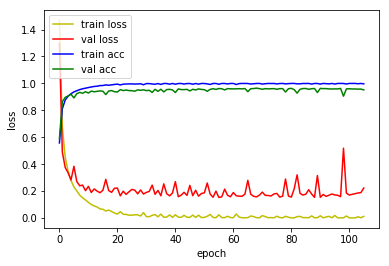

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2127 - acc: 0.9439
Loss: 0.21272355242596547 Accuracy: 0.94392526

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0943 - acc: 0.6694
Epoch 00001: val_loss improved from inf to 0.79151, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_checkpoint/001-0.7915.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.0942 - acc: 0.6694 - val_loss: 0.7915 - val_acc: 0.7652
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4148 - acc: 0.8796
Epoch 00002: val_loss improved from 0.79151 to 0.37259, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_checkpoint/002-0.3726.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.4147 - acc: 0.8796 - val_loss: 0.3726 - val_acc: 0.8889
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2796 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9963
Epoch 00027: val_loss did not improve from 0.14620
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0155 - acc: 0.9963 - val_loss: 0.2102 - val_acc: 0.9490
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9897
Epoch 00028: val_loss did not improve from 0.14620
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0378 - acc: 0.9896 - val_loss: 0.1785 - val_acc: 0.9518
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9945
Epoch 00029: val_loss did not improve from 0.14620
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0231 - acc: 0.9944 - val_loss: 0.1566 - val_acc: 0.9571
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9965
Epoch 00030: val_loss did not improve from 0.14620
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9998
Epoch 00057: val_loss did not improve from 0.13890
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0016 - acc: 0.9998 - val_loss: 0.1481 - val_acc: 0.9653
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9997
Epoch 00058: val_loss did not improve from 0.13890
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0016 - acc: 0.9997 - val_loss: 0.1610 - val_acc: 0.9616
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9914
Epoch 00059: val_loss did not improve from 0.13890
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0271 - acc: 0.9914 - val_loss: 0.1571 - val_acc: 0.9604
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9996
Epoch 00060: val_loss did not improve from 0.13890
36805/36805 [===========

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9979
Epoch 00087: val_loss did not improve from 0.13890
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0068 - acc: 0.9979 - val_loss: 0.3379 - val_acc: 0.9264
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9970
Epoch 00088: val_loss did not improve from 0.13890
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0103 - acc: 0.9970 - val_loss: 0.1464 - val_acc: 0.9632
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9998
Epoch 00089: val_loss did not improve from 0.13890
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1600 - val_acc: 0.9618
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9999
Epoch 00090: val_loss did not improve from 0.13890
36805/36805 [===========

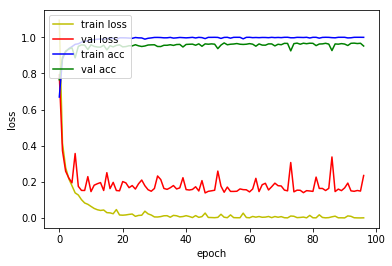

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2005 - acc: 0.9456
Loss: 0.20049218032837904 Accuracy: 0.9455867



In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_________________________________________________________________
4815/4815 [==============================] - 3s 602us/sample - loss: 2.4178 - acc: 0.2471
Loss: 2

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8905 - acc: 0.7323
Loss: 0.8905373923256142 Accuracy: 0.7322949

1D_CNN_6_conv_custom_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 6

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3502 - acc: 0.9148
Loss: 0.35023604480091286 Accuracy: 0.9148494

1D_CNN_8_conv_custom_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 16000, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2005 - acc: 0.9456
Loss: 0.20049218032837904 Accuracy: 0.9455867
